In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, accuracy_score, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("Bank_Transaction_Fraud_Detection.csv")
# 1. Drop kolom yang tidak diperlukan sebelum split
drop_cols = [
    'Customer_ID', 'Customer_Name', 'Transaction_ID', 'Merchant_ID',
    'Customer_Contact', 'Customer_Email', 'Transaction_Date', 'Transaction_Time',
    'Transaction_Location', 'Transaction_Description'
]

# Drop langsung dari df
df = df.drop(columns=drop_cols)

# 2. Visualize numerical columns
df_numeric = df.select_dtypes(include='number')
n_vars = df_numeric.shape[1]
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

df.head()

,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Device_Type,Is_Fraud,Transaction_Currency
0,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,32415.45,Transfer,Restaurant,74557.27,Voice Assistant,POS,0,INR
1,Female,51,Maharashtra,Nashik,Nashik Branch,Business,43622.60,Bill Payment,Restaurant,74622.66,POS Mobile Device,Desktop,0,INR
2,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,63062.56,Bill Payment,Groceries,66817.99,ATM,Desktop,0,INR
3,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,14000.72,Debit,Entertainment,58177.08,POS Mobile App,Mobile,0,INR
4,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,18335.16,Transfer,Entertainment,16108.56,Virtual Card,Mobile,0,INR


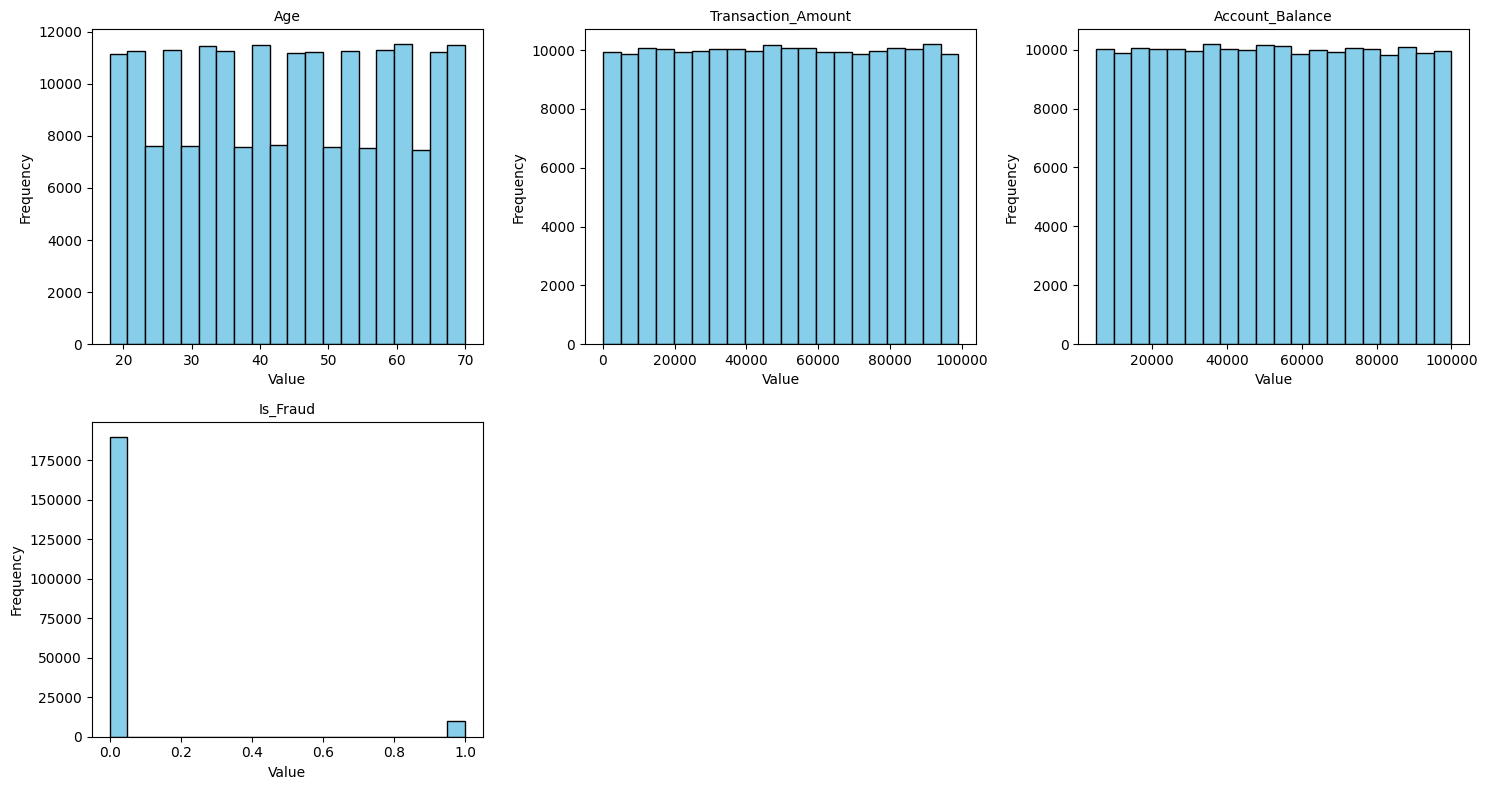

In [3]:
plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i in range(n_vars):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(df_numeric.iloc[:, i], bins=20, color='skyblue', edgecolor='black')
    plt.title(df_numeric.columns[i], fontsize=10)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [4]:
print("Variabel Types: \n", df.dtypes)

Variabel Types: 
 Gender                   object
Age                       int64
State                    object
City                     object
Bank_Branch              object
Account_Type             object
Transaction_Amount      float64
Transaction_Type         object
Merchant_Category        object
Account_Balance         float64
Transaction_Device       object
Device_Type              object
Is_Fraud                  int64
Transaction_Currency     object
dtype: object


In [5]:
# 1. Drop kolom yang tidak diperlukan + target
X = df.drop(columns=['Is_Fraud'])
y = df['Is_Fraud']
df = df.dropna(subset=['Is_Fraud'])  # Drop rows with NaN in 'Is_Fraud' column

# Reset index after dropping rows
df = df.reset_index(drop=True)

In [6]:
print("Missing Value:\n", df.isnull().sum())

Missing Value:
 Gender                  0
Age                     0
State                   0
City                    0
Bank_Branch             0
Account_Type            0
Transaction_Amount      0
Transaction_Type        0
Merchant_Category       0
Account_Balance         0
Transaction_Device      0
Device_Type             0
Is_Fraud                0
Transaction_Currency    0
dtype: int64


In [7]:
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} unique values")

Gender: 2 unique values
State: 34 unique values
City: 145 unique values
Bank_Branch: 145 unique values
Account_Type: 3 unique values
Transaction_Type: 5 unique values
Merchant_Category: 6 unique values
Transaction_Device: 20 unique values
Device_Type: 4 unique values
Transaction_Currency: 1 unique values


In [8]:
print("", df['Gender'].value_counts())
print("\n", df['Account_Type'].value_counts())
print("\n", df['Transaction_Type'].value_counts())
print("\n", df['Merchant_Category'].value_counts())
print("\n", df['Device_Type'].value_counts())
print("\n", df['Is_Fraud'].value_counts())

 Gender
Male      100452
Female     99548
Name: count, dtype: int64

 Account_Type
Checking    66924
Savings     66593
Business    66483
Name: count, dtype: int64

 Transaction_Type
Credit          40180
Debit           40050
Bill Payment    40040
Transfer        39953
Withdrawal      39777
Name: count, dtype: int64

 Merchant_Category
Restaurant       33525
Entertainment    33421
Electronics      33409
Clothing         33340
Groceries        33187
Health           33118
Name: count, dtype: int64

 Device_Type
POS        50111
ATM        50055
Mobile     49962
Desktop    49872
Name: count, dtype: int64

 Is_Fraud
0    189912
1     10088
Name: count, dtype: int64


In [9]:
gender_map = {"Gender": {"Male": 1, "Female": 0}}
X = X.replace(gender_map)

<ipython-input-9-f886b687c568>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace(gender_map)


In [10]:
cat_cols = ['Account_Type', 'Transaction_Type', 'Merchant_Category', 'Device_Type']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = ohe.fit_transform(df[cat_cols]) # Use updated df
encoded_cols = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=df.index)

X_numeric = X.drop(columns=cat_cols)
X_final = pd.concat([X_numeric, encoded_cols], axis=1)

# Finally, split the data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

X_train.head()


,Gender,Age,State,City,Bank_Branch,Transaction_Amount,Account_Balance,Transaction_Device,Transaction_Currency,Account_Type_Business,...,Merchant_Category_Clothing,Merchant_Category_Electronics,Merchant_Category_Entertainment,Merchant_Category_Groceries,Merchant_Category_Health,Merchant_Category_Restaurant,Device_Type_ATM,Device_Type_Desktop,Device_Type_Mobile,Device_Type_POS
24751,1,46,Karnataka,Belgaum,Belgaum Branch,46096.24,40115.15,Self-service Banking Machine,INR,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
64910,1,38,Kerala,Trichur,Trichur Branch,7128.55,74920.03,ATM Booth Kiosk,INR,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
82415,1,35,Assam,Dibrugarh,Dibrugarh Branch,2528.04,49674.34,Voice Assistant,INR,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
195460,0,37,Tamil Nadu,Coimbatore,Coimbatore Branch,38486.10,85695.70,Biometric Scanner,INR,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
141623,1,50,Tripura,Dharmanagar,Dharmanagar Branch,88828.68,32891.92,Virtual Card,INR,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
X_numeric = X.select_dtypes(include=['int64', 'float64'])

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4. SMOTE untuk balancing
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
from sklearn.preprocessing import LabelEncoder
print(y_res.value_counts())

Class distribution after SMOTE:
Is_Fraud
0    151930
1    151930
Name: count, dtype: int64


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = XGBClassifier(eval_metric='logloss')
scores = cross_val_score(model, X_train, y_train_encoded, cv=5)  # 5-fold cross-validation
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

Cross-validation scores: [0.6946005  0.69112151 0.69029149 0.69330042 0.69111425]
Mean cross-validation score: 0.6920856336529886


In [13]:
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_res)
# Update the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_encoded, test_size=0.3, random_state=42)

# Initialize and train XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Decode the predictions back to the original labels for interpretation
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:30:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6965817591434652
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.65      0.68     45595
           1       0.68      0.74      0.71     45563

    accuracy                           0.70     91158
   macro avg       0.70      0.70      0.70     91158
weighted avg       0.70      0.70      0.70     91158



===== Threshold: 0.3 =====

Confusion Matrix:
[[13505 32090]
 [ 1775 43788]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.30      0.44     45595
           1       0.58      0.96      0.72     45563

    accuracy                           0.63     91158
   macro avg       0.73      0.63      0.58     91158
weighted avg       0.73      0.63      0.58     91158



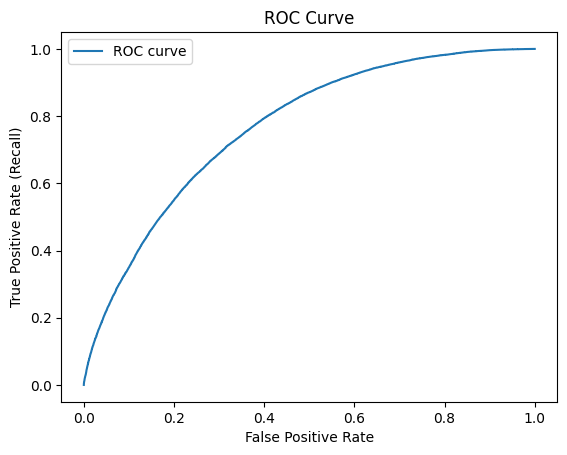

In [14]:
# 1. Prediksi probabilitas kelas 1 (fraud)
y_proba = xgb.predict_proba(X_test)[:, 1]

# 2. Gunakan threshold tetap = 0.3
fixed_threshold = 0.3
y_pred_fixed = (y_proba >= fixed_threshold).astype(int)

# 3. Decode prediksi ke label asli
y_pred_labels_fixed = label_encoder.inverse_transform(y_pred_fixed)
y_test_labels = label_encoder.inverse_transform(y_test)

# 4. Evaluasi hasil
print(f"===== Threshold: {fixed_threshold} =====")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels_fixed))

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels_fixed))

# 5. (Opsional) Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [15]:
import pickle

# Save your model, label encoder, and anything needed for prediction
with open('fraud_detection_model.pkl', 'wb') as f:
    pickle.dump({
        'model': xgb,
        'label_encoder': label_encoder
    }, f)

print("✅ Model and Label Encoder saved as 'fraud_detection_model.pkl'")

✅ Model and Label Encoder saved as 'fraud_detection_model.pkl'


ModuleNotFoundError: No module named 'streamlit'